In [5]:
# Generate a BAM file with only reads from non_spanning_reads and length >= 50000
from pathlib import Path
import pysam

bam_select = "/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam"
# Define the output BAM file path
non_spanning_bam = output_dir / "non_spanning_reads_filtered.bam"

# Convert the list to a set for faster lookup
non_spanning_reads_set = set(non_spanning_reads)

# Define the minimum read length
min_read_length = 50000

# Open the original BAM file and create a new BAM file for non-spanning reads
with pysam.AlignmentFile(bam_select, "rb") as bam_in, \
     pysam.AlignmentFile(non_spanning_bam, "wb", template=bam_in) as bam_out:
    
    # Iterate over all reads in the BAM file
    for read in bam_in:
        # Calculate the read length
        read_length = read.query_length  # Alternatively, use read.reference_end - read.reference_start
        
        # Check if the read is in non_spanning_reads and meets the length requirement
        if read.query_name in non_spanning_reads_set and read_length >= min_read_length:
            bam_out.write(read)


[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


KeyboardInterrupt: 

In [ ]:
# Generate a BAM file with only reads from non_spanning_reads and length >= 50000
from pathlib import Path
import pysam

bam_select = "/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam"
# Define the output BAM file path
spanning_bam = output_dir / "spanning_reads_filtered.bam"

# Convert the list to a set for faster lookup
spanning_reads_set = set(spanning_reads)

# Define the minimum read length
min_read_length = 50000

# Open the original BAM file and create a new BAM file for non-spanning reads
with pysam.AlignmentFile(bam_select, "rb") as bam_in, \
     pysam.AlignmentFile(spanning_bam, "wb", template=bam_in) as bam_out:
    
    # Iterate over all reads in the BAM file
    for read in bam_in:
        # Calculate the read length
        read_length = read.query_length  # Alternatively, use read.reference_end - read.reference_start
        
        # Check if the read is in non_spanning_reads and meets the length requirement
        if read.query_name in spanning_reads_set and read_length >= min_read_length:
            bam_out.write(read)


In [2]:
from pathlib import Path
from matplotlib import pyplot as plt

import pysam 
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import itertools
from tabulate import tabulate
import csv
import random

np.set_printoptions(threshold=np.inf)
min_quality_score = 8



assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

start_time = time.time()

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
end_time = time.time()
elapsed_time = end_time - start_time
print (elapsed_time, "seconds")
assembly_.close()



57.62561297416687 seconds


In [3]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')


In [4]:
''' here in the code, I am formulating the CDR regions and listing the CDRs in each and every chromosome'''
input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_dict = {}
with open(input_file, 'r') as infile:  
    for i in infile:
        chr_num = i.split('\t')[0]
        CDR_start = i.split('\t')[1]
        CDR_end = i.split('\t')[2].split('\n')[0]
        if chr_num not in CDR_dict:
            CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
        elif chr_num in CDR_dict:  
            CDR_dict[chr_num].append ([CDR_start ,CDR_end])





In [5]:
# Open the BAM file
bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")

def read_spans_regions(read, regions):
    start_list = []
    span_count = 0
    for region in regions:
        start = int(region[0])
        end = int(region[1])
        #if read.reference_start < end and read.reference_end > start   :
        if read.reference_start <= start and  read.reference_end  >= end:
            span_count += 1
            start_list.append(start)

    return span_count, start_list


# Bins to store read names
spanning_reads = {}
non_spanning_reads = []

# Iterate over chromosomes in the dictionary
for chromosome, regions in CDR_dict.items():
    for read in bamfile.fetch(chromosome):
        if read.query_length > 50000:
            span_count,start_list = read_spans_regions(read, regions)
            if span_count >= 2: 
                spanning_reads[read.query_name] = start_list




# Print the bins
print("Reads spanning two or more regions:")



[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


Reads spanning two or more regions:


In [5]:
import pysam

def add_yc_tag(bam_file, read_names, output_bam_file, yc_value=10):
    # Load BAM file
    bam = pysam.AlignmentFile(bam_file, "rb")
    
    # Open an output BAM file
    output_bam = pysam.AlignmentFile(output_bam_file, "wb", template=bam)
    
    # Convert the read names list into a set for faster lookups
    read_names_set = set(read_names)
    
    # Iterate through the BAM file
    for read in bam.fetch():
        # Check if the read name is in the provided list
        if read.query_name in read_names_set:
            # Add or update the YC tag
            read.set_tag("YC", yc_value)
        
        # Write the read to the new BAM file
        output_bam.write(read)
    
    # Close the files
    bam.close()
    output_bam.close()


output_bam_file = output_dir / "spanning_reads_YC_tagged.bam"
add_yc_tag(CENPA_AS_bam_file, spanning_reads, output_bam_file, yc_value=10)


[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


In [6]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '-' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))


    
    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]



    target_start_dash = indexes.index (target_start_no_dash)

        
    try:
        target_end_dash = indexes.index (target_end_no_dash)
    except ValueError: 
        target_end_dash = indexes[-1]




    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset





In [7]:
''' 
The input of the function is a dictionary in the format of 'chromosome':[[start,end],[start,end]] 
'''
def region_read_mA_density_calculator (chromosome_coordinates,threshold,mod_tag): 
    read_region_check = {}
    read_CDR_region_distribution = {}


    #get each chromosome
    for chr_name in chromosome_coordinates:

        for region in chromosome_coordinates[chr_name]:
            region_base = 0 

            region_start_index = int(region[0])
            region_end_index = int(region[1])

            
            for read in bamfile.fetch(chr_name,region_start_index,region_end_index):
                read_name = read.query_name 
                    
                if read_name in spanning_reads :
                    
                    #make an if statement to check a specific read front, middle, end regions 
                    #setting read start, end, density, length variables 
                        

                    #Get the starting and ending positions of the reads 
                    read_start_position = read.reference_start
                    read_end_position = read.reference_end
                    read_density = 0 

                    
                    #Get sequence information which shows deletions and insertions 
                    sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)


                    #make |a numpy of the sequence length which eliminates the deletion
                    read_sequence_insertion_included = ''
                    genomic_alignment_sequence_deletion_mistach_included = ''
                    
                    for item in sequence:
                        if item[0] is None:
                            read_sequence_insertion_included+='-'
                        elif item[1] is None:
                            genomic_alignment_sequence_deletion_mistach_included += '-'
                        else: 
                            read_sequence_insertion_included+=item[2]
                            genomic_alignment_sequence_deletion_mistach_included +=item[2]

                    
                    #take sequence length excluding insertions 
                    read_sequence_insertion_included = read_sequence_insertion_included.upper()
                    genomic_alignment_sequence_deletion_mistach_included = genomic_alignment_sequence_deletion_mistach_included.upper()
                    
                    genomic_alignment_sequence_deletion_mistach_included_mask = np.array(
                    [char != '-' for char in genomic_alignment_sequence_deletion_mistach_included])

                    insertions = read_sequence_insertion_included.count ("-")
                    no_insertion_no_deletion_sequence_length = len(read_sequence_insertion_included)

                    #make a mod np array with the length of the read length
                    mod=read.modified_bases_forward
                    
                    #make a mod score with its original length 
                    mod_score = np.zeros(len(genomic_alignment_sequence_deletion_mistach_included),)
                    try:
                        if mod_tag == 'A':
                            for indices, values in mod[('A', 0, 'a')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            


                        elif mod_tag == 'CG':
                            for indices, values in mod[('C', 0, 'm')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                        
                        if read.is_reverse:
                                mod_score = mod_score[::-1]


                    # No mod would return KeyError 
                    except KeyError:
                        continue
                        


                    # if the regions are longer than the reads 
                    if (region_end_index - region_start_index) > (read_end_position - read_start_position):
                        # if the reads are inside the region
                        if (region_end_index >= read_end_position) and (region_start_index <= read_start_position): 
                            mod_start = 0
                            mod_end = len(read_sequence_insertion_included)
                        
                        # if the reads cover the later part of the region
                        elif (region_end_index < read_end_position) and (region_start_index > read_start_position): 
                            mod_start = 0
                            mod_end = no_insertion_no_deletion_sequence_length - read_end_position - region_end_index

                        # if the reads cover the starting part of the region 
                        elif (region_end_index > read_end_position) and (region_start_index > read_start_position): 
                            mod_start = region_start_index - read_start_position 
                            mod_end = no_insertion_no_deletion_sequence_length

                            
                    
                    # if the reads are longer than the region selected 
                    elif (region_end_index - region_start_index) <= (read_end_position - read_start_position):
                        # scenario 1: when the defined region is inside the read
                        if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                            mod_start = region_start_index - read_start_position 
                            mod_end = region_end_index - read_start_position

                        # scenario 3: when the defined region covers a bit of the end of the read
                        elif (read_end_position < region_end_index) and (read_end_position > region_start_index):
                            mod_start = region_start_index - read_start_position
                            mod_end = no_insertion_no_deletion_sequence_length

                        # scenario 2: when the defined region covers a bit of the beginning of the read
                        elif (read_start_position > region_start_index) and (read_start_position < region_end_index):
                            mod_start = 0
                            mod_end = region_end_index - read_start_position 

                    #use the defined starting and ending positons in the region to subset mod numpy
                    if (region_start_index - read_start_position) > (no_insertion_no_deletion_sequence_length - insertions):
                        continue
                    try:
                        trimmed_mod_score = mod_subset_producing_step (mod_score,read_sequence_insertion_included,mod_start,mod_end)
                    except ValueError:
                        continue
                    
                
                    region_base += (mod_end - mod_start)
                    #removing all the zeros 
                    mod_no_zeros = trimmed_mod_score[trimmed_mod_score != 0]
                    m_mod_tag = len (mod_no_zeros)
                    

                    #Getting the total amount of As in the subsetted region of the sequence 
                    total_mod_tag = read_sequence_insertion_included[mod_start:mod_end].count(mod_tag)
                
                
                    #calculate read density
                    try:
                        read_density = m_mod_tag / total_mod_tag
                        if read_name in read_CDR_region_distribution:
                            read_CDR_region_distribution[read_name].append ([m_mod_tag,total_mod_tag,region_start_index])
                        else: 
                            read_CDR_region_distribution[read_name] = [[m_mod_tag,total_mod_tag,region_start_index]]
                        
                    except ZeroDivisionError:
                        pass

                    


                    if read_density >= threshold:
                        read_CDR_location_density = {}
                        read_CDR_location_density[region_start_index] = read_density
                        if read_name in read_region_check: 
                            read_region_check[read_name].append (read_CDR_location_density)
                        else: 
                            read_region_check[read_name]= [read_CDR_location_density]
                    else: 
                        read_CDR_location_density = {}
                        read_CDR_location_density[region_start_index] = 0
                        if read_name in read_region_check: 
                            read_region_check[read_name].append (read_CDR_location_density)
                        else: 
                            read_region_check[read_name]= [read_CDR_location_density]

    return  read_region_check, read_CDR_region_distribution

                                



  

                
            #calculate averaged region density average 


    

In [9]:
bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")
reads_spanning_dict, reads_CDR_mA_distribution_dict = region_read_mA_density_calculator (CDR_dict,0.0095,"A")

[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


In [17]:
filtered_reads_spanning_dict = {}
for key, dict_list in reads_spanning_dict.items():
    if key in spanning_reads:
        filtered_list = [d for d in dict_list if list(d.keys())[0] in spanning_reads[key]]
        filtered_reads_spanning_dict[key] = filtered_list


# Filtering logic
filtered_reads_CDR_mA_distribution_dict = {}
for key, sublist in reads_CDR_mA_distribution_dict.items():
    if key in spanning_reads:
        # Filter sublists
        filtered_sublist = [entry for entry in sublist if entry[2] in spanning_reads[key]]
        # Remove the third element from each sublist
        filtered_sublist = [entry[:2] for entry in filtered_sublist]
        filtered_reads_CDR_mA_distribution_dict[key] = filtered_sublist


print (len(filtered_reads_spanning_dict))
# Path to your text file containing the keys to remove
keys_to_remove_file = '/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region/reads.txt'

# Read the keys to remove from the text file into a set
with open(keys_to_remove_file, 'r') as file:
    keys_to_remove = set(line.strip() for line in file)

# Remove the keys from the dictionary
for key in keys_to_remove:
    filtered_reads_spanning_dict.pop(key, None)  # Use pop with default None to avoid KeyError if key not present
    filtered_reads_CDR_mA_distribution_dict.pop(key, None)  # Use pop with default None to avoid KeyError if key not present
    
print (len(filtered_reads_spanning_dict))





1907
1389


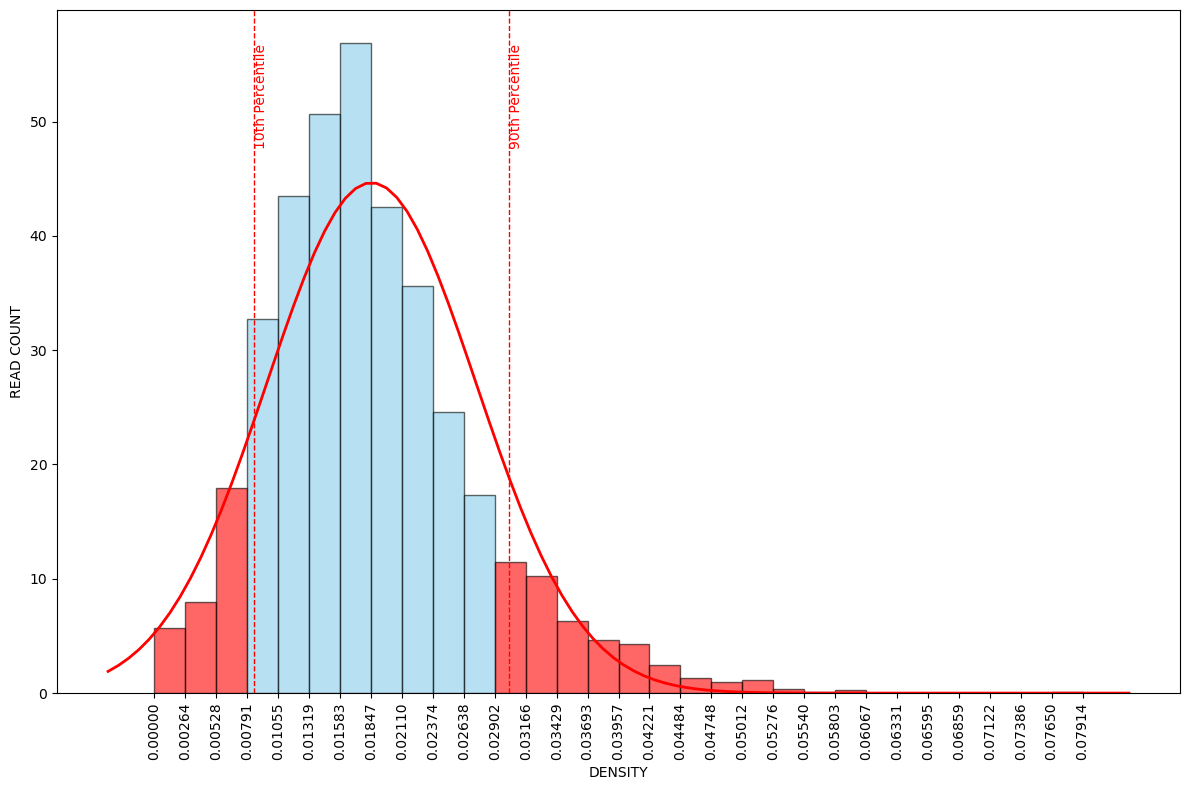

In [13]:
distribution_result = {
    key: sum(pair[0] for pair in values) / sum(pair[1] for pair in values) if sum(pair[1] for pair in values) != 0 else 0
    for key, values in reads_CDR_mA_distribution_dict.items()
}
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(distribution_result, orient='index', columns=['Ratio'])

# Calculate mean and standard deviation
mu, std = norm.fit(df['Ratio'])

# Define number of bins
num_bins = 30

# Calculate the 10th and 90th percentiles
lower_percentile = 10
upper_percentile = 90
lower_bound = np.percentile(df['Ratio'], lower_percentile)
upper_bound = np.percentile(df['Ratio'], upper_percentile)

# Plot histogram
plt.figure(figsize=(12, 8))
counts, bin_edges, patches = plt.hist(
    df['Ratio'],
    bins=num_bins,
    density=True,
    alpha=0.6,
    color='skyblue',
    edgecolor='black'
)

# Plot the normal distribution fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

# Set x-axis ticks at each bin edge and rotate them vertically
plt.xticks(bin_edges, rotation=90)

# Highlight bins within the lower and upper percentiles
for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
    bin_center = (left_edge + right_edge) / 2
    if bin_center <= lower_bound or bin_center >= upper_bound:
        patch.set_facecolor('red')

# Add vertical lines to indicate the percentile bounds
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=1)
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=1)
plt.text(lower_bound, plt.ylim()[1]*0.95, f'{lower_percentile}th Percentile', color='red', rotation=90, verticalalignment='top')
plt.text(upper_bound, plt.ylim()[1]*0.95, f'{upper_percentile}th Percentile', color='red', rotation=90, verticalalignment='top')

plt.xlabel('DENSITY')
plt.ylabel('READ COUNT')
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
data = []
for primary_key, secondary_dicts in filtered_reads_spanning_dict.items():
    # Count of secondary dictionaries
    num_cdr = len(secondary_dicts)
    # Count of non-zero values in secondary dictionaries
    num_cenpa_enrichment_domains = sum(
        1 for secondary_dict in secondary_dicts if list(secondary_dict.values())[0] != 0
    )
    # Add row to data list
    data.append([primary_key, num_cdr, num_cenpa_enrichment_domains])

# Convert to DataFrame
filtered_reads_spanning_dict = pd.DataFrame(data, columns=['read_name', '# of CDR', '# of CENPA enrichment domains'])






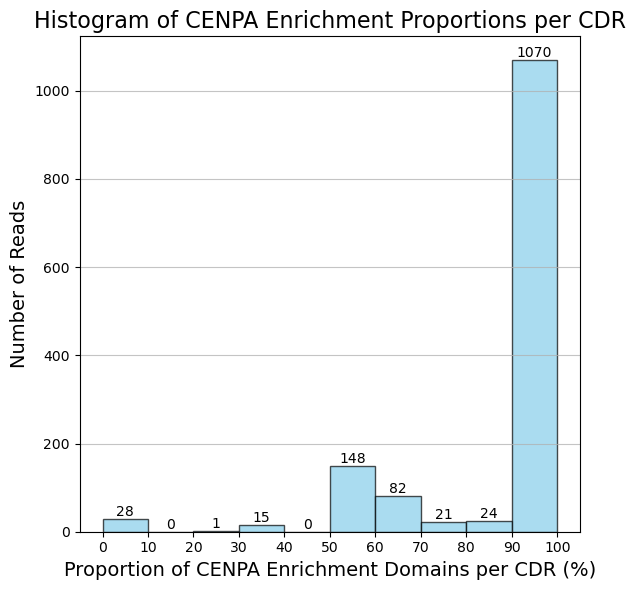

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming reads_spanning_df is already created and has the following columns:
# 'read_name', '# of CDR', '# of CENPA enrichment domains'

# Step 1: Calculate the proportionality of # of CENPA divided by # of CDR in percentage
# Handle division by zero by replacing zero # of CDR with NaN or a small number
filtered_reads_spanning_dict['Proportion_CENPA_per_CDR (%)'] = (
    filtered_reads_spanning_dict['# of CENPA enrichment domains'] / filtered_reads_spanning_dict['# of CDR'] * 100
)

# Optional: Handle infinite or undefined proportions if # of CDR is zero
# For example, you can set them to zero or remove those entries
filtered_reads_spanning_dict.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
filtered_reads_spanning_dict.dropna(subset=['Proportion_CENPA_per_CDR (%)'], inplace=True)

# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    filtered_reads_spanning_dict['Proportion_CENPA_per_CDR (%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='skyblue'
)

# Step 4: Customize the plot
plt.xlabel('Proportion of CENPA Enrichment Domains per CDR (%)', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
plt.title('Histogram of CENPA Enrichment Proportions per CDR', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


In [61]:

# Export the DataFrame to a CSV file

reads_spanning_df.to_csv(output_dir /'output.csv', index=False)


In [16]:
import pandas as pd


# Set display option to show all rows
pd.set_option('display.max_rows', None)



# Define the lower and upper bounds
lower_bound = 0
upper_bound = 10

# Filter the DataFrame using 'between'
filtered_df = reads_spanning_df[
    reads_spanning_df['Proportion_CENPA_per_CDR (%)'].between(lower_bound, upper_bound)
]

# Print the number of rows in the filtered DataFrame
print(f"Total number of rows: {len(filtered_df)}")

# Print the filtered DataFrame


# Extract the "read name" column from the filtered DataFrame
read_names = filtered_df['read_name']

# Define the output file path
output_file_path = "/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/read.txt"

# Write the read names to the specified file
read_names.to_csv(output_file_path, index=False, header=False)





Total number of rows: 240


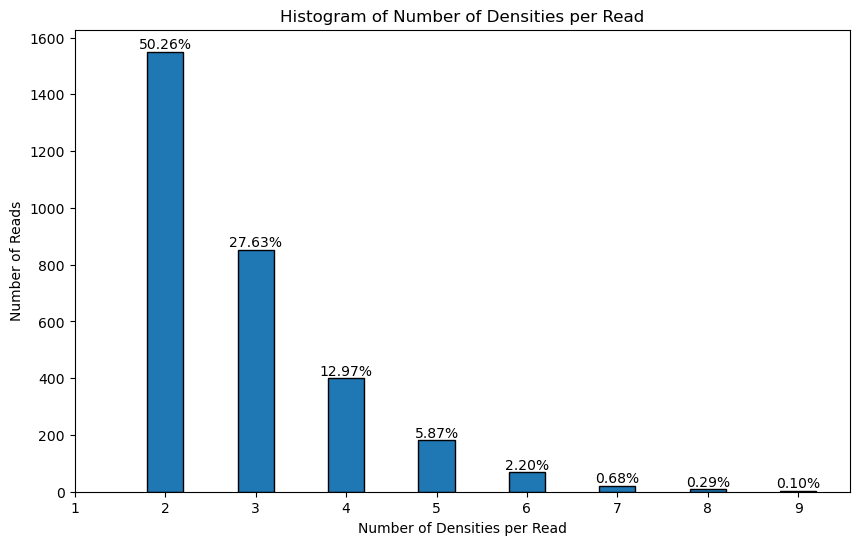

In [17]:
# Extract the number of densities for each read

# Extract the number of densities for each read
num_densities = [len(densities) for densities in reads_spanning_dict.values()]

# Count the occurrences of each number of densities
density_counts = {}
for count in num_densities:
    if count in density_counts:
        density_counts[count] += 1
    else:
        density_counts[count] = 1

# Prepare data for the bar plot
x = list(density_counts.keys())
y = list(density_counts.values())

# Calculate percentages
total_reads = sum(y)
percentages = [(count / total_reads) * 100 for count in y]

# Plotting the bar plot with percentages
plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, width=0.4, edgecolor='black')

# Add percentages above bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Number of Densities per Read')
plt.ylabel('Number of Reads')
plt.title('Histogram of Number of Densities per Read')
plt.xticks(range(1, max(x) + 1))

# Show the plot
plt.show()


In [ ]:
# Find reads with exactly 7 densities
reads_with_7_densities = [read_name for read_name, densities in reads_spanning_dict.items() if len(densities) == 7]

# Print the reads with 7 densities
print("Reads with exactly 7 densities:")
print(reads_with_7_densities)

Reads with exactly 7 densities:
['14d951f3-cbab-4919-9994-f528e6ebb48d', '9fc03e50-95ac-4cdb-bbe9-c7d1665e1686', '800a1436-08e7-422d-94d4-3fbe1cb0d99f', '65fd77c2-b991-433b-9bd6-6df629f6e5e6', 'ae464b8f-b20f-4dc0-a0b1-089bcf0bb74c', '359796ba-ba0d-4fcc-b1fc-c8dd653b21b3', '004dc25d-5e8c-477a-b281-3e7ea5a1a45f', '51661c3b-fe78-428e-bb74-1743d9c065c4', 'dd2bbad4-f26d-481c-949c-705436c7c49f', 'a2df5726-3950-40d4-8cb4-dd746fbf0e8b', '52e4fa55-de24-45ac-8dc7-f8b2b2b4298a', 'a9f8f517-a1a4-4a6c-aac1-54369c5dc8a7', '3900d172-f720-466b-9a7b-3e383296d0dc', 'e35dad7c-5885-463e-9476-20cafff94480']
